# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
 -1
  1
  1
 -1
  1
  1
  1
  1
  1
  ⋮
  1
  1
 -1
  1
  1
  1
  1
  1
  1

### We create a function to visualize the data

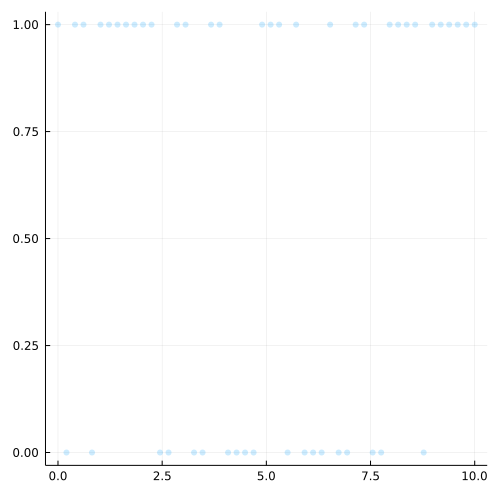

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.149551 seconds (1.85 M allocations: 98.327 MiB, 99.60% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.8412478732712421, 0.8627714642921313, 0.9133272323412921, 0.9866533933759953, 1.0696123625224703, 1.1462312714874074, 1.2006766664133877, 1.220892446483611, 1.2002256613150017, 1.1387195769381513  …  0.8930521839723499, 1.0143780665183773, 1.1309461156716822, 1.2342321293252838, 1.3177383099516746, 1.3759850579028925, 1.4057389331740708, 1.406196812109122, 1.3796087600543585, 1.3313894274527274], θ = [0.2362299789914422, 0.23556570385156608, 0.23395835252515879, 0.2315163560597813, 0.22860916671900086, 0.2258024856264796, 0.22374478020100297, 0.22296850642380645, 0.22376202543912418, 0.22608241699217782  …  0.2346107407141513, 0.23056104727339002, 0.2263710494931112, 0.22245283595889787, 0.2191673202098439, 0.2168231458049052, 0.2156111525084261, 0.21559243014094667, 0.216676036500228

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:50
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:58
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:58
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:28
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:11
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:59
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:50
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:31
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:29
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.9740909920277523, 1.1355476014711952, 1.2909423958101267, 1.3819304576141795, 1.5026507412307175, 1.579568143578516, 1.7156836149254397, 1.8630200613928953, 2.051555675525403, 2.2181159919313336  …  0.48857034964332513, 0.4244660724924875, 0.28508606466731334, 0.1292385928234987, -0.029873230727581523, -0.15401224646233147, -0.2485877926513551, -0.29180049019868726, -0.24673530121970422, -0.18556274867715739]]
 [[-0.12128582070363747, 0.20158358993121062, 0.5496083657274056, 0.8431154311563764, 1.1173024821839925, 1.2407638790891986, 1.3017404592597963, 1.2542449835425769, 1.1181536013499191, 0.9534962083841931  …  1.312768522930188, 1.4829996129290066, 1.5596511788855512, 1.5655886480495678, 1.4597233676639152, 1.2321642571964424, 0.8532473414468656, 0.3943469652298126, -0.1381545404583917, -0.6496702156500986]]
 [[-0.6759922580532853, -0.46941581830453155, -0.20749215299728535, 0.08415254176052978, 0.34741734631965576, 0.568093455995

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

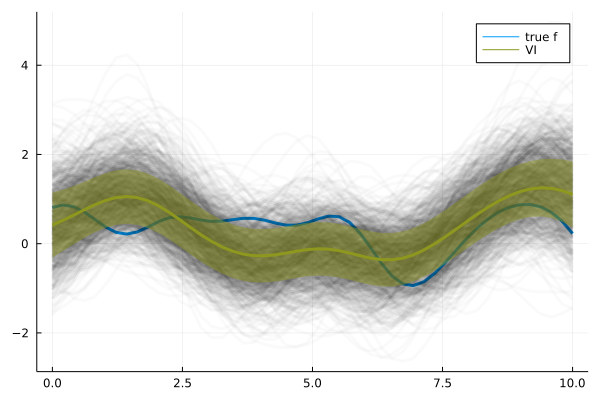

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

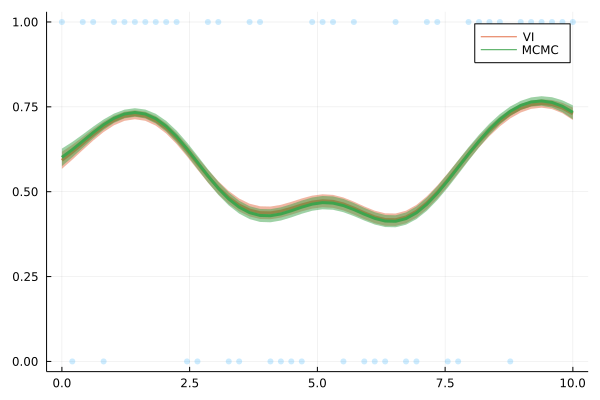

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*